# **Pre-amble**

In [ ]:
# Mount drive
from google.colab import drive; drive.mount('/content/drive')

# CD to current directory
%cd /content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Notebooks


In [ ]:
cbscolor = (73/255, 103/255, 170/255)

In [ ]:
! sudo apt-get update
! sudo apt-get install texlive-latex-recommended
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
! unzip type1cm.zip -d /tmp/type1cm
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
! sudo texhash
!apt install cm-super

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,683 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 Packages [77.3 kB]
Get:13 http://security

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns

# Optuna download
!pip install -q optuna==3.4.0
!pip install -q optuna-integration
import optuna

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble": r"""
        \usepackage{type1cm}
        \usepackage{amsmath}
    """
})

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 3.9 MB/s eta 0:00:00


# **1 SGD Differences**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) define loss and gradient
def loss(theta):
    x, y = theta
    return 0.5 * (x**2 + y**2)

def grad(theta):
    x, y = theta
    return np.array([x, y])

# 2) gradient descent simulator
def run_gd(grad_fn, theta0, lr, n_iter, batch_size):
    theta = theta0.copy()
    path = [theta.copy()]
    for _ in range(n_iter):
        if batch_size is None:
            g = grad_fn(theta)               # full-batch
        elif batch_size == 1:
            g = grad_fn(theta) + np.random.randn(2) * 0.3  # stochastic
        else:
            g = grad_fn(theta) + np.random.randn(2) * 0.1  # mini-batch
        theta -= lr * g
        path.append(theta.copy())
    return np.array(path)

# Parameters
np.random.seed(0)
theta0 = np.array([2.0, 2.0])
lrs = [0.1, 0.5, 1.0]  # learning rates
methods = [
    ("Full-batch", None),
    ("Mini-batch", 32),
    ("Stochastic", 1),
]

# prepare contour grid
grid = np.linspace(-1, 2, 200)
Θ1, Θ2 = np.meshgrid(grid, grid)
L_vals = 0.5 * (Θ1**2 + Θ2**2)

# Create 3x3 grid
fig, axes = plt.subplots(nrows=len(lrs), ncols=3, figsize=(16, 6), sharex=True, sharey=True, dpi=600)

for i, lr in enumerate(lrs):
    for j, (name, batch_size) in enumerate(methods):
        path = run_gd(grad, theta0, lr=lr, n_iter=100, batch_size=batch_size)
        ax = axes[i, j]
        ax.contour(Θ1, Θ2, L_vals, levels=15, alpha=0.5, linewidths=0.5, cmap="gray")
        ax.plot(path[:, 0], path[:, 1], marker='o', markersize=2, linewidth=0.5, color="black", markeredgecolor=cbscolor)

        # Column titles
        if i == 0:
            ax.set_title(name, fontsize=14)
        # Theta labels only on outer edges
        if j == 0:
            ax.set_ylabel(r'$\theta_2$', fontsize=12)
        if i == len(lrs) - 1:
            ax.set_xlabel(r'$\theta_1$', fontsize=12)
        ax.grid(linestyle='--', alpha=0.4)

# Add a vertical "axis" of learning rate labels on the left
for i, lr in enumerate(lrs):
    fig.text(0.04, 1 - (i + 0.5) / len(lrs), rf'$\eta={lr}$', va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.savefig("gradient_descent_paths.pdf", bbox_inches='tight')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# **2 Loss Over Seaches**

## **2.1 Gather Losses**

In [ ]:
# FFNN Studies
searches = ["first", "second", "third", "fourth", "final"]
ffnn = {}

for s in searches:
  ffnn[s] = optuna.load_study(study_name=s+"_search", storage="sqlite:///Feed Forward Neural Nets/models studies/"+s+"_search.db")

In [ ]:
# RNN Studies
dffnn = {}


dffnn['first'] = optuna.load_study(study_name="first_search", storage="sqlite:///Deep Neural Networks/models studies/D-FFNN studies/first_study_25-60Layers.db")
dffnn['second'] = optuna.load_study(study_name="2_second_search", storage="sqlite:///Deep Neural Networks/models studies/D-FFNN studies/2_second_study_25-60Layers (1).db")
dffnn['final'] = optuna.load_study(study_name="2_second_search", storage="sqlite:///Deep Neural Networks/models studies/D-FFNN studies/2_second_study_25-60Layers (1).db")

In [ ]:
# RNN Studies
searches = ["first", "second", "third", "fourth", "fifth", "final"]
rnn = {}

for s in searches:
  rnn[s] = optuna.load_study(study_name=s+"_search", storage="sqlite:///Recurrent Neural Nets/models studies/"+s+"_search.db")

In [ ]:
# LSTM Studies
searches = ["first", "second", "third", "fourth", "final"]
lstm = {}

for s in searches:
  lstm[s] = optuna.load_study(study_name="new_LSTM_"+s+"_search.db", storage="sqlite:///LSTM/models studies/LSTM studies/new_LSTM_"+s+"_search.db")

## **2.2 Create Histograms**

In [ ]:
# FFNN Studies
searches = ["first", "second", "third", "fourth", "final"]
for s in searches:
  ffnn[s] = ffnn[s].trials_dataframe()[ffnn[s].trials_dataframe()['state'] == 'COMPLETE']['value'].values

In [ ]:
# DFFNN Studies
dffnn['first'] = dffnn['first'].trials_dataframe()[dffnn['first'].trials_dataframe()['state'] == 'COMPLETE']['value'].values

dffnn['second'] = dffnn['second'].trials_dataframe()[0:59]
dffnn['second'] = dffnn['second'][dffnn['second']['state'] == 'COMPLETE']['value'].values

dffnn['final'] = dffnn['final'].trials_dataframe()[60:]
dffnn['final'] = dffnn['final'][dffnn['final']['state'] == 'COMPLETE']['value'].values

In [ ]:
# RNN Studies
searches = ["first", "second", "third", "fourth", "fifth", "final"]
for s in searches:
  rnn[s] = rnn[s].trials_dataframe()[rnn[s].trials_dataframe()['state'] == 'COMPLETE']['value'].values

In [ ]:
# LSTM Studies
searches = ["first", "second", "third", "fourth", "final"]
for s in searches:
  lstm[s] = lstm[s].trials_dataframe()[lstm[s].trials_dataframe()['state'] == 'COMPLETE']['value'].values

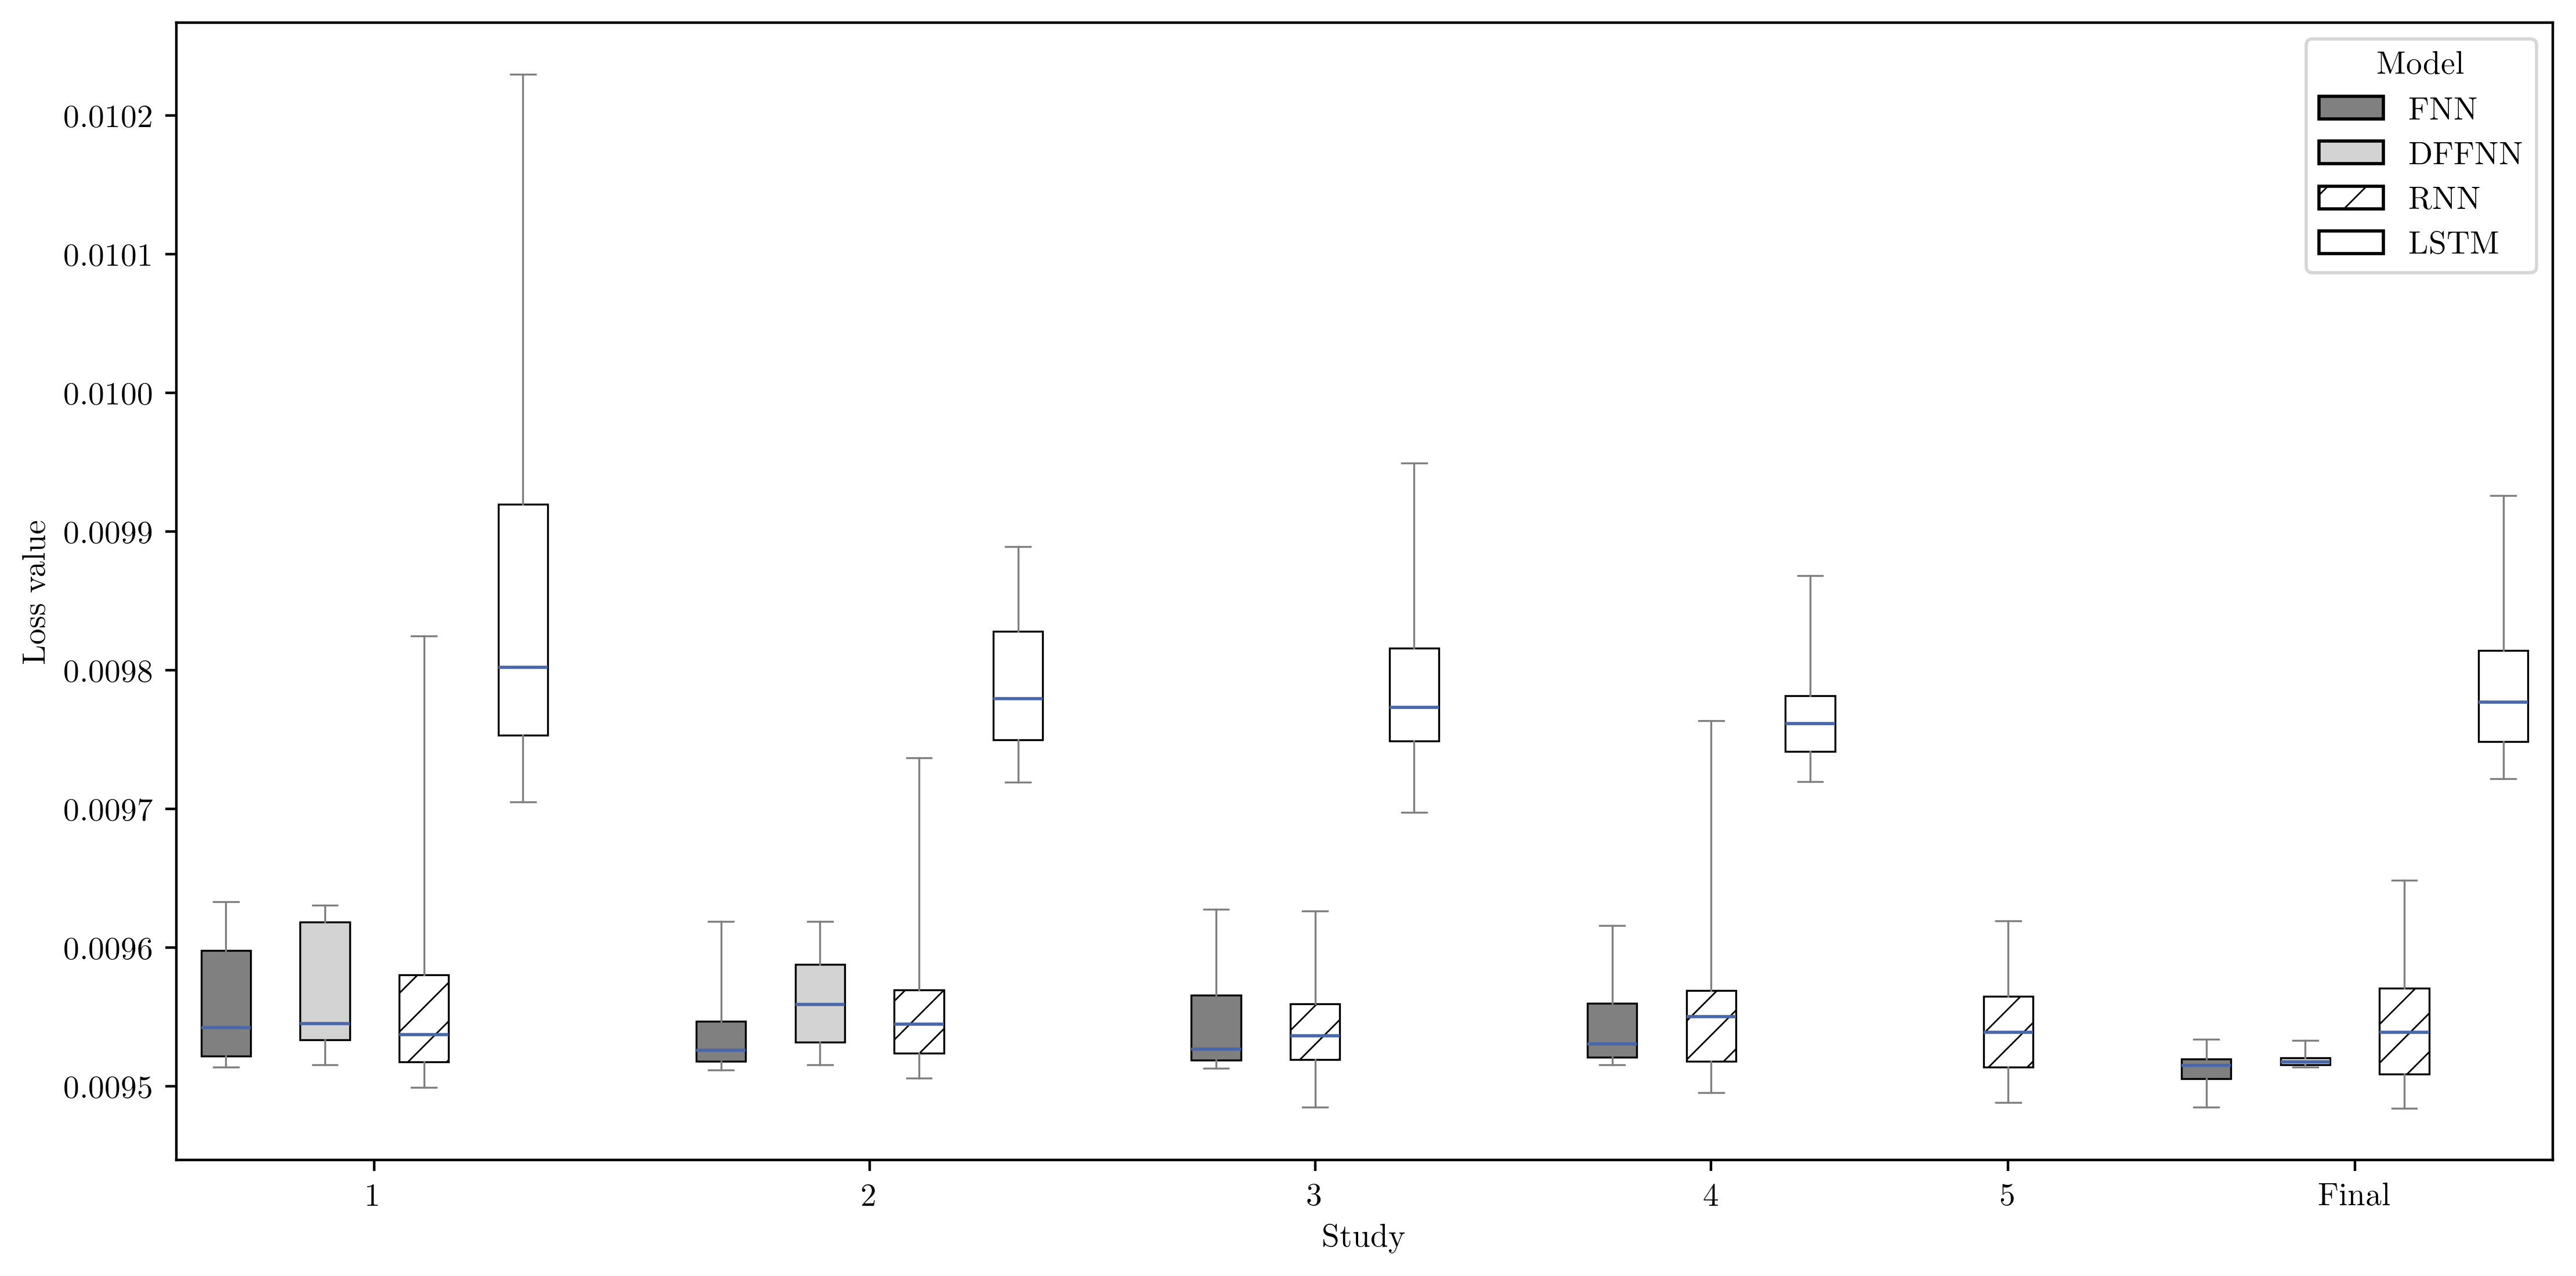

In [97]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

mpl.rcParams['hatch.linewidth'] = 0.5

# 1) neutral colors per model
model_colors = {
    'FNN':  'gray',
    'DFFNN': 'lightgray',
    'RNN':  'white',
    'LSTM': 'white'
}

models = {
    'FNN':  ffnn,
    'DFFNN': dffnn,
    'RNN':  rnn,
    'LSTM': lstm
}

search_order = ["first", "second", "third", "fourth", "fifth", "final"]

# 2) collect data *and* the exact positions for each search‐group
data_to_plot  = []
box_models    = []
group_positions = []   # list of lists

pos = 1
for search in search_order:
    this_group = []    # positions of the boxes in this search
    for mdl, d in models.items():
        if search in d:
            data_to_plot.append(d[search])
            box_models.append(mdl)
            this_group.append(pos)
            pos += 1
    if this_group:
        group_positions.append((search, this_group))
    pos += 1   # gap before next group

# 3) flatten all those group_positions into a single positions list
positions = [p for (_s, grp) in group_positions for p in grp]

# 4) draw
plt.rcParams['text.usetex'] = True
fig, ax = plt.subplots(figsize=(14*0.8, 7*0.8), dpi=400)
bplot = ax.boxplot(
    data_to_plot,
    positions=positions,
    widths=0.5,
    whis=4,
    showfliers=False,
    patch_artist=True,
    boxprops     = dict(linewidth=0.6),
    whiskerprops = dict(linewidth=0.6),
    capprops     = dict(linewidth=0.6),
    medianprops  = dict(linewidth=1.0)
)

# 5) color boxes by model
for patch, mdl in zip(bplot['boxes'], box_models):
    patch.set_facecolor(model_colors[mdl])
    if mdl == 'RNN':
        patch.set_hatch('//')   # adds diagonal stripes
for patch, mdl in zip(bplot['boxes'], box_models):
    patch.set_facecolor(model_colors[mdl])
for line in bplot['whiskers'] + bplot['caps']:
    line.set_color('gray')
for m in bplot['medians']:
    m.set_color(cbscolor)

# 6) compute one tick‐position per non‐empty search‐group
centers = [np.mean(grp) for (_s, grp) in group_positions]
labels  = [str(i+1) if s!='final' else 'Final'
           for i,(s,_) in enumerate(group_positions)]

ax.set_xticks(centers)
ax.set_xticklabels(labels, ha='center')

# 7) legend for models
handles = [Patch(facecolor=clr,
                 edgecolor='black',
                 hatch='//' if mdl == 'RNN' else None,
                 label=mdl)
           for mdl, clr in model_colors.items()]
ax.legend(handles=handles, title="Model", loc='upper right')

ax.set_ylabel("Loss value")
ax.set_xlabel("Study")
plt.tight_layout()
plt.savefig("parametersearch.pdf", bbox_inches='tight', dpi=600)
plt.show()

# **3 Autocorrelation**

First we load data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

In [ ]:
# Relative location of data
DATA_RLOC = 'Data/handoffs/data_stock_returns_final.parquet'

# Load data and sort by eom
securities_data = pd.read_parquet(DATA_RLOC)
securities_data = securities_data.sort_values(by=['id', 'eom'])

# List of features and the label
features = [
    feat for feat in securities_data.columns
    if feat not in ['eom', 'id', 'ret_exc_lead1m']
]

label = 'ret_exc_lead1m'

We compute the autocorrelation in the features.

In [ ]:
df = securities_data[['id'] + features]
df_long = df.melt(id_vars='id', var_name='feature', value_name='value')


def compute_lag1_acf(values):
    if len(values) > 1:
        return acf(values, nlags=1, fft=False)[1]
    else:
        return np.nan

autocorrs = (
    df_long
    .groupby(['id', 'feature'])['value']
    .apply(compute_lag1_acf)
    .reset_index(name='acf')
)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


We now also compute the autocorrelation in the labels.

In [ ]:
df_label = securities_data[['id', 'ret_exc_lead1m']]

# 2. Group by stock_id and compute lag-1 autocorrelation
def compute_lag1_acf(values):
    if len(values) > 1:
        return acf(values, nlags=1, fft=False)[1]
    else:
        return np.nan

autocorrs_label = (
    df_label
    .groupby('id')['ret_exc_lead1m']
    .apply(compute_lag1_acf)
    .reset_index(name='acf')
)

Below we create the plots.

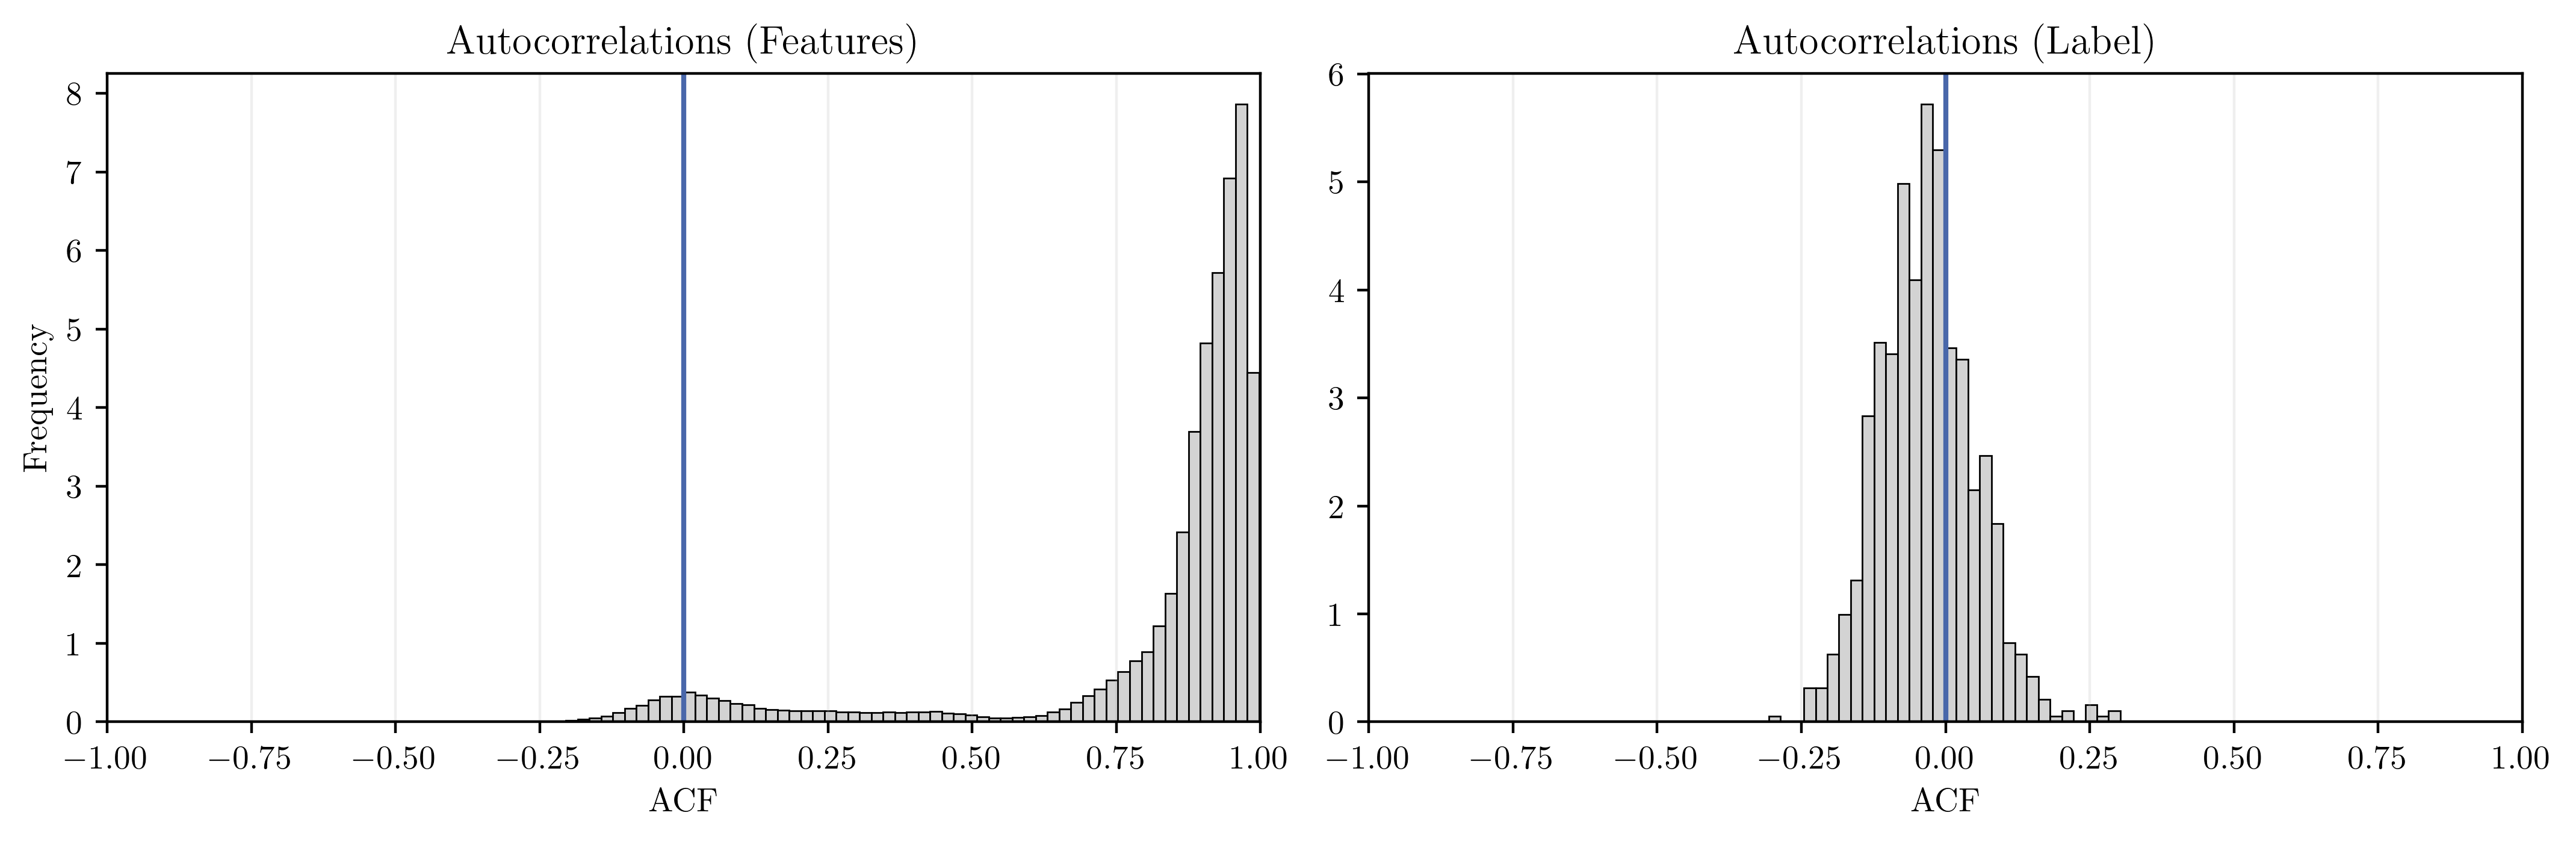

In [95]:
acf1 = autocorrs['acf'].dropna().values
acf2 = autocorrs_label['acf'].dropna().values

# Set up figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18*0.6, 6*0.6), dpi=400)

# Histogram 1
axes[0].hist(acf1, bins=70, color='lightgray', linewidth=0.5, edgecolor='black',  density=True)
axes[0].set_xlim(-1, 1)
axes[0].set_title('Autocorrelations (Features)')
axes[0].set_xlabel('ACF')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='x', alpha=.2)
axes[0].axvline(x=0, color=cbscolor, linewidth=1.5)


# Histogram 2
axes[1].hist(acf2, bins=30, color='lightgray', linewidth=0.5, edgecolor='black',  density=True)
axes[1].set_xlim(-1, 1)
axes[1].set_title('Autocorrelations (Label)')
axes[1].set_xlabel('ACF')
axes[1].grid(axis='x', alpha=.2)
axes[1].axvline(x=0, color=cbscolor, linewidth=1.5)


# Layout
plt.tight_layout()
plt.savefig("autocorrelation.pdf", bbox_inches='tight', dpi=600)
plt.show()